# Training&Evaluation of a developed algorithm

In this python notebook you can try several possible architectures and train&evaluate them.

1. Create a Summarizer&Classifier class. Has several options to set up: with or without features (right now without features works better), bert or roberta as basis (no big difference), you can also choose frozen_strategy (froze_all in case you don't want to improve bert layers but only the summarization layer, unfroze_last4 -- modifies bert weights and still training not very slow, unfroze_all -- the training is slow, the results may better though)

In [1]:
import torch.nn as nn
import torch
import numpy as np
from transformers import BertModel, RobertaModel
from collections import namedtuple
from transformers import BertTokenizer, RobertaTokenizer
from pysrc.review.train.preprocess import parse_sents, standardize, greedy_selection

import pysrc.review.config as cfg
from pysrc.review.utils import get_ids_mask


SpecToken = namedtuple('SpecToken', ['tkn', 'idx'])
ConvertToken2Id = lambda tokenizer, tkn: tokenizer.convert_tokens_to_ids([tkn])[0]


class Summarizer(nn.Module):

    enc_output: torch.Tensor
    rouges_values: np.array = np.zeros(4)
    dec_ids_mask: torch.Tensor
    encdec_ids_mask: torch.Tensor

    def __init__(self, model_type, article_len, with_features=False, num_features=10):
        super(Summarizer, self).__init__()

        self.article_len = article_len

        if model_type == 'bert':
            self.backbone, self.tokenizer, BOS, EOS, PAD = self.initialize_bert()
        elif model_type == 'roberta':
            self.backbone, self.tokenizer, BOS, EOS, PAD = self.initialize_roberta()
        else:
            raise Exception(f"Wrong model_type argument: {model_type}")
            
        if with_features:
            self.features = nn.Sequential(nn.Linear(num_features, 100),
                                          nn.ReLU(),
                                          nn.Linear(100, 100),
                                          nn.ReLU(),
                                          nn.Linear(100, 50))
        else:
            self.features = None

        self.PAD = SpecToken(PAD, ConvertToken2Id(self.tokenizer, PAD))
        self.artBOS = SpecToken(BOS, ConvertToken2Id(self.tokenizer, BOS))
        self.artEOS = SpecToken(EOS, ConvertToken2Id(self.tokenizer, EOS))

        # add special tokens tokenizer
        self.tokenizer.add_special_tokens({'additional_special_tokens': ["<sum>", "</sent>", "</sum>"]})
        self.vocab_size = len(self.tokenizer)
        self.sumBOS = SpecToken("<sum>", ConvertToken2Id(self.tokenizer, "<sum>"))
        self.sumEOS = SpecToken("</sent>", ConvertToken2Id(self.tokenizer, "</sent>"))
        self.sumEOA = SpecToken("</sum>", ConvertToken2Id(self.tokenizer, "</sum>"))
        self.backbone.resize_token_embeddings(200 + self.vocab_size)

        # tokenizer
        self.tokenizer.PAD = self.PAD
        self.tokenizer.artBOS = self.artBOS
        self.tokenizer.artEOS = self.artEOS
        self.tokenizer.sumBOS = self.sumBOS
        self.tokenizer.sumEOS = self.sumEOS
        self.tokenizer.sumEOA = self.sumEOA
        self.vocab_size = len(self.tokenizer)

        # initialize backbone emb pulling
        def backbone_forward(input_ids, input_mask, input_segment, input_pos):
            return self.backbone(
                input_ids=input_ids,
                attention_mask=input_mask,
                token_type_ids=input_segment,
                position_ids=input_pos,
            )
        self.encoder = lambda *args: backbone_forward(*args)[0]

        # initialize decoder
        if not with_features:
            self.decoder = Classifier(cfg.d_hidden)
        else:
            self.decoder = Classifier(cfg.d_hidden + 50)

    def expand_posembs_ifneed(self):
        print(self.backbone.config.max_position_embeddings, self.article_len)
        if self.article_len > self.backbone.config.max_position_embeddings:
            print("OK")
            old_maxlen = self.backbone.config.max_position_embeddings
            old_w = self.backbone.embeddings.position_embeddings.weight
            cfg.logger.log(f"Backbone pos embeddings expanded from {old_maxlen} upto {self.article_len}")
            self.backbone.embeddings.position_embeddings = \
                nn.Embedding(self.article_len, self.backbone.config.hidden_size)
            self.backbone.embeddings.position_embeddings.weight[:old_maxlen].data.copy_(old_w)
            self.backbone.config.max_position_embeddings = self.article_len
        print(self.backbone.config.max_position_embeddings)

    @staticmethod
    def initialize_bert():
        backbone = BertModel.from_pretrained(
            "bert-base-uncased", output_hidden_states=False
        )
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

        BOS = "[CLS]"
        EOS = "[SEP]"
        PAD = "[PAD]"
        return backbone, tokenizer, BOS, EOS, PAD

    @staticmethod
    def initialize_roberta():
        backbone = RobertaModel.from_pretrained(
            'roberta-base', output_hidden_states=False
        )
        # initialize token type emb, by default roberta doesn't have it
        backbone.config.type_vocab_size = 2
        backbone.embeddings.token_type_embeddings = nn.Embedding(2, backbone.config.hidden_size)
        backbone.embeddings.token_type_embeddings.weight.data.normal_(
            mean=0.0, std=backbone.config.initializer_range
        )
        tokenizer = RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=True)
        BOS = "<s>"
        EOS = "</s>"
        PAD = "<pad>"
        return backbone, tokenizer, BOS, EOS, PAD

    def save(self, save_filename):
        """ Save model in filename

        :param save_filename: str
        """
        if not self.features:
            state = {
                'encoder_dict': self.backbone.state_dict(),
                'decoder_dict': self.decoder.state_dict(),
            }
        else:
            state = {
                'encoder_dict': self.backbone.state_dict(),
                'decoder_dict': self.decoder.state_dict(),
                'features_dict': self.features.state_dict(),
            }
            
        torch.save(state, f"{cfg.weights_path}/{save_filename}.pth")

    def load(self, load_filename):
        path = f"{cfg.weights_path}/{load_filename}.pth"
        state = torch.load(path, map_location=lambda storage, location: storage)
        self.backbone.load_state_dict(state['encoder_dict'])
        self.decoder.load_state_dict(state['decoder_dict'])
        if self.features:
            self.features.load_state_dict(state['features_dict'])
        

    def froze_backbone(self, froze_strategy):

        assert froze_strategy in ['froze_all', 'unfroze_last4', 'unfroze_all'],\
            f"incorrect froze_strategy argument: {froze_strategy}"

        if froze_strategy == 'froze_all':
            for name, param in self.backbone.named_parameters():
                param.requires_grad_(False)

        elif froze_strategy == 'unfroze_last4':
            for name, param in self.backbone.named_parameters():
                param.requires_grad_(True if (
                    'encoder.layer.11' in name or
                    'encoder.layer.10' in name or
                    'encoder.layer.9' in name or
                    'encoder.layer.8' in name
                ) else False)

        elif froze_strategy == 'unfroze_all':
            for param in self.backbone.parameters():
                param.requires_grad_(True)

    def unfroze_head(self):

        for name, param in self.decoder.named_parameters():
            param.requires_grad_(True)

    @property
    def rouge_1(self):
        return self.rouges_values[0]

    @property
    def rouge_2(self):
        return self.rouges_values[1]

    @property
    def rouge_l(self):
        return self.rouges_values[2]

    @property
    def rouge_mean(self):
        return self.rouges_values[3]

    def forward(self, input_ids, input_mask, input_segment, input_features=None):
        """ Train for 1st stage of model

        :param input_ids: torch.Size([batch_size, article_len])
        :param input_mask: torch.Size([batch_size, article_len])
        :param input_segment: torch.Size([batch_size, article_len])
        :return:
            logprobs | torch.Size([batch_size, summary_len, vocab_size])
        """
        
        cls_mask = (input_ids == self.artBOS.idx)

        # position ids | torch.Size([batch_size, article_len])
        pos_ids = torch\
            .arange(0, self.article_len, dtype=torch.long, device=input_ids.device)\
            .unsqueeze(0)\
            .repeat(len(input_ids), 1)
        # extract bert embeddings | torch.Size([batch_size, article_len, d_bert])
        enc_output = self.encoder(input_ids, input_mask, input_segment, pos_ids)
        
        if self.features:
            temp_features = self.features(input_features)
            draft_logprobs = self.decoder(torch.cat([enc_output[cls_mask], temp_features], dim=-1))
        else:
            draft_logprobs = self.decoder(enc_output[cls_mask])

        return draft_logprobs

    def evaluate(self, input_ids, input_mask, input_segment, input_features=None):
        """ Eval for 1st stage of model

        :param input_ids: torch.Size([batch_size, article_len])
        :param input_mask: torch.Size([batch_size, article_len])
        :param input_segment: torch.Size([batch_size, article_len])
        :return:
            draft_ids | torch.Size([batch_size, summary_len])
        """

        cls_mask = (input_ids == self.artBOS.idx)

        # position ids | torch.Size([batch_size, article_len])
        pos_ids = torch\
            .arange(0, self.article_len, dtype=torch.long, device=input_ids.device)\
            .unsqueeze(0)\
            .repeat(len(input_ids), 1)
        # extract bert embeddings | torch.Size([batch_size, article_len, d_bert])
        enc_output = self.encoder(input_ids, input_mask, input_segment, pos_ids)

        ans = []
        for eo, cm in zip(enc_output, cls_mask):
            if self.features:
                scores = self.decoder.evaluate(torch.cat([eo[cm], self.features(input_features)], dim=-1))
            else:
                scores = self.decoder.evaluate(eo[cm])
            ans.append(scores)
        return ans


class Classifier(nn.Module):
    def __init__(self, hidden_size):
        super(Classifier, self).__init__()
        self.linear1 = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.linear1(x).squeeze(-1)
        scores = self.sigmoid(x)
        return scores

    def evaluate(self, x):
        x = self.linear1(x).squeeze(-1)
        scores = self.sigmoid(x)
        return scores

2. train_fun -- training function for model without features. train_fun_ft -- training function for model with features

In [2]:
from torch.optim.optimizer import Optimizer
from tqdm import tqdm
import math
from pysrc.review.utils import get_enc_lr, get_dec_lr

def backward_step(loss: torch.Tensor, optimizer: Optimizer, model: nn.Module, clip: float, amp_enabled: int):
    loss.backward()
    total_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
    return total_norm

def train_fun(model, dataloader, optimizer, scheduler, criter, device, rank, writer, distributed):

    # draft, refine
    model.train()
    model_ref = model.module if distributed else model

    pbar = tqdm(enumerate(dataloader), total=len(dataloader), leave=False, disable=rank != 0)
    for idx_batch, batch in pbar:
        
        input_ids, input_mask, input_segment, target_scores = \
            [(x.to(device) if isinstance(x, torch.Tensor) else x) for x in batch]
        target_scores = torch.cat(target_scores).to(device)

        # forward pass
        draft_probs = model(
            input_ids, input_mask, input_segment,
        )

        try:
        # loss
            loss = criter(
                draft_probs,
                target_scores,
            )
        except Exception:
            print(idx_batch, draft_probs.shape, target_scores.shape, input_segment)
            return

        # backward
        grad_norm = backward_step(loss, optimizer, model, optimizer.clip_value, amp_enabled=cfg.amp_enabled)
        grad_norm = 0 if (math.isinf(grad_norm) or math.isnan(grad_norm)) else grad_norm

        # record a loss value
        # loss_val += loss.item() * len(input_ids)
        pbar.set_description(f"loss:{loss.item():.2f}")
        writer.add_scalar(f"Train/loss", loss.item(), writer.train_step)
        writer.add_scalar("Train/grad_norm", grad_norm, writer.train_step)
        writer.add_scalar("Train/lr_enc", get_enc_lr(optimizer), writer.train_step)
        writer.add_scalar("Train/lr_dec", get_dec_lr(optimizer), writer.train_step)
        writer.train_step += 1

        # make a gradient step
        if (idx_batch + 1) % optimizer.accumulation_interval == 0 or (idx_batch + 1) == len(dataloader):
            optimizer.step()
            optimizer.zero_grad()
        scheduler.step()

    # overall loss per epoch
    # if distributed:
    #     loss_val = distribute(loss_val, device)
    # cfg.logger.log(f"mean loss: {loss_val / len(dataloader.dataset):.4f}", is_print=rank == 0)

    # save model, just in case
    if rank == 0:
        model_ref.save('temp')

    return model, optimizer, scheduler, writer

def train_fun_ft(model, dataloader, optimizer, scheduler, criter, device, rank, writer, distributed):

    # draft, refine
    model.train()
    model_ref = model.module if distributed else model

    pbar = tqdm(enumerate(dataloader), total=len(dataloader), leave=False, disable=rank != 0)
    for idx_batch, batch in pbar:
        
        input_ids, input_mask, input_segment, target_scores, input_features = \
            [(x.to(device) if isinstance(x, torch.Tensor) else x) for x in batch]
        target_scores = torch.cat(target_scores).to(device)
        input_features = torch.cat(input_features).to(device)
        # forward pass
        draft_probs = model(
            input_ids, input_mask, input_segment, input_features,
        )

        try:
        # loss
            loss = criter(
                draft_probs,
                target_scores,
            )
        except Exception:
            print(idx_batch, draft_probs.shape, target_scores.shape, input_segment)
            return

        # backward
        grad_norm = backward_step(loss, optimizer, model, optimizer.clip_value, amp_enabled=cfg.amp_enabled)
        grad_norm = 0 if (math.isinf(grad_norm) or math.isnan(grad_norm)) else grad_norm

        # record a loss value
        # loss_val += loss.item() * len(input_ids)
        pbar.set_description(f"loss:{loss.item():.2f}")
        writer.add_scalar(f"Train/loss", loss.item(), writer.train_step)
        writer.add_scalar("Train/grad_norm", grad_norm, writer.train_step)
        writer.add_scalar("Train/lr_enc", get_enc_lr(optimizer), writer.train_step)
        writer.add_scalar("Train/lr_dec", get_dec_lr(optimizer), writer.train_step)
        writer.train_step += 1

        # make a gradient step
        if (idx_batch + 1) % optimizer.accumulation_interval == 0 or (idx_batch + 1) == len(dataloader):
            optimizer.step()
            optimizer.zero_grad()
        scheduler.step()

    # overall loss per epoch
    # if distributed:
    #     loss_val = distribute(loss_val, device)
    # cfg.logger.log(f"mean loss: {loss_val / len(dataloader.dataset):.4f}", is_print=rank == 0)

    # save model, just in case
    if rank == 0:
        model_ref.save('temp')

    return model, optimizer, scheduler, writer

3. load_data loads all the needed datafiles for building train dataset. The several next steps are only should be done if no train/test/val datasets are saved

In [3]:
import pandas as pd

def load_data(root2data):
    abstracts_df = pd.read_csv(root2data / "abstracts.csv", sep='\t')
    sentences_df = pd.read_csv(root2data / "sentences.csv", sep='\t')
    filelist_df = pd.read_csv(root2data / "filelist.csv", sep=',')
    review_files_df = pd.read_csv(root2data / "review_files.csv", sep='\t')
    figures_df = pd.read_csv(root2data / "figures.csv", sep='\t')
    reverse_ref_df = pd.read_csv(root2data / "reverse_ref.csv", sep='\t')
    citations_df = pd.read_csv(root2data / "citations.csv", sep='\t')
    tables_df = pd.read_csv(root2data / "tables.csv", sep='\t')
    return sentences_df, abstracts_df, filelist_df, review_files_df, figures_df, reverse_ref_df, citations_df, tables_df

4. get_rouge function will be needed anyway. You can uncomment rouge-l, if you want. 

In [ ]:
from rouge import Rouge

ROUGE_METER = Rouge()
TOKENIZER = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def get_rouge(sent1, sent2):
    sent_1 = TOKENIZER.tokenize(sent1)
    #print(sent_1)
    sent_1 = " ".join(list(filter(lambda x: x.isalpha() or x in '.!,?', sent_1)))
    #print(sent_1)
    sent_2 = TOKENIZER.tokenize(sent2)
    sent_2 = " ".join(list(filter(lambda x: x.isalpha() or x in '.!,?', sent_2)))
    rouges = ROUGE_METER.get_scores(sent_1, sent_2)[0]
    rouges = [rouges[f'rouge-{x}']["f"] for x in ('1', '2')] # , 'l')]
    return np.mean(rouges) * 100

In [33]:
get_rouge("I am scout. True!", "No you are not a scout.")

['i', 'am', 'scout', '.', 'true', '!']
i am scout . true !


12.023460245257912

5. Several functions needed to build the datasets. If the datasets alredy exist, do not have to run this cell.

In [5]:
from unidecode import unidecode
from nltk.tokenize import sent_tokenize
import re

REPLACE_SYMBOLS = {
    '—': '-',
    '–': '-',
    '―': '-',
    '…': '...',
    '´´': "´",
    '´´´': "´´",
    "''": "'",
    "'''": "'",
    "``": "`",
    "```": "`",
    ":": " : ",
}

def parse_sents(data):
    sents = sum([sent_tokenize(text) for text in data], [])
    sents = list(filter(lambda x: len(x) > 3, sents))
    return sents

def standardize(text):
    def sent_standardize(sent):
        sent = unidecode(sent)
        sent = re.sub(r"\[(xref_\w*_\w\d*]*)(, xref_\w*_\w\d*)*\]", " ", sent)  # delete [xref,...]
        sent = re.sub(r"\( (xref_\w*_\w\d*)(; xref_\w*_\w\d*)* \)", " ", sent)  # delete (xref; ...)
        sent = re.sub(r"\[xref_\w*_\w\d*\]", " ", sent)  # delete [xref]
        sent = re.sub(r"xref_\w*_\w\d*", " ", sent)  # delete [[xref]]
        for k, v in REPLACE_SYMBOLS.items():
            sent = sent.replace(k, v)
        return sent.strip()
    text = [sent_standardize(sent) for sent in text]
    return list(filter(lambda x: len(x) > 3, text))



def preprocess_paper(paper_id, sentences_df, ref_sents_df):
    preprocessed_score = []
    paper = sentences_df[sentences_df['pmid'] == paper_id]['sentence'].values
    paper = standardize(paper)
    ref_sents = ref_sents_df[ref_sents_df['ref_pmid'] == paper_id]['sentence'].values
    #print(ref_sents)
    ref_sents = standardize(ref_sents)
    if len(paper) < 50:
        return None
            
    if len(paper) > 100:
        result_paper = paper[:50]
        result_paper += paper[-50:]
        paper = result_paper
    
    for sent in paper:
        score = 0
        for ref_sent in ref_sents:
            score += get_rouge(sent, ref_sent)
        score /= len(ref_sents)
        preprocessed_score.append(score)
    return paper, preprocessed_score

def preprocess_paper_with_features(paper_id, sentences_df, ref_sents_df, abstracts_df, \
                                   figures_df, reverse_ref_df, tables_df):
    preprocessed_score = []
    features = []
    
    paper = sentences_df[sentences_df['pmid'] == paper_id]['sentence'].values
    paper = standardize(paper)
    
    sent_ids = sentences_df[sentences_df['pmid'] == paper_id]['sent_id'].values
    
    sent_types = sentences_df[sentences_df['pmid'] == paper_id]['type'].values
    
    ref_sents = ref_sents_df[ref_sents_df['ref_pmid'] == paper_id]['sentence'].values
    ref_sents = standardize(ref_sents)
    
    fig_captions = figures_df[figures_df['pmid'] == paper_id]['caption'].values
    fig_captions = standardize(fig_captions)
    
    tab_captions = tables_df[tables_df['pmid'] == paper_id]['caption'].values
    tab_captions = standardize(tab_captions)
    
    abstract = abstracts_df[abstracts_df['pmid'] == paper_id]['abstract'].values
    if len(abstract) != 0:
        abstract = standardize(abstract)
    #print(ref_sents)
    
    tmp_df = reverse_ref_df[reverse_ref_df['pmid'] == paper_id]
    
    if len(paper) < 50:
        return None
            
    if len(paper) > 100:
        result_paper = paper[:50]
        result_paper += paper[-50:]
        paper = result_paper
        sent_ids = list(sent_ids[:50]) + list(sent_ids[-50:])
        sent_types = list(sent_types[:50]) + list(sent_types[-50:])
        
        
    def mean_rouge(sent, text):
        try:
            score = 0
            for ref_sent in text:
                score += get_rouge(sent, ref_sent)
            score /= len(text)
            return score
        except Exception:
            return None
    def min_rouge(sent, text):
        try:
            score = 100000000
            for ref_sent in text:
                score = min(get_rouge(sent, ref_sent), score)
            if score == 100000000:
                return None
            return score
        except Exception:
            return None
    def max_rouge(sent, text):
        try:
            score = -100000
            for ref_sent in text:
                score = max(get_rouge(sent, ref_sent), score)
            if score == -100000:
                return None
            return score
        except Exception:
            return None
    
    for i, sent in enumerate(paper):
        score = mean_rouge(sent, ref_sents)
        if score is None:
            return None
        try:
            abst_diff = get_rouge(sent, abstract[0])
        except Exception:
            abst_diff = None
        num_refs = len(tmp_df[(tmp_df['sent_type'] == sent_types[i]) & (tmp_df['sent_id'] == sent_ids[i])])
        features.append((sent_ids[i], int(sent_types[i] == "general"), abst_diff, num_refs,\
                        mean_rouge(sent, fig_captions), mean_rouge(sent, tab_captions),\
                        min_rouge(sent, fig_captions), min_rouge(sent, tab_captions), \
                        max_rouge(sent, fig_captions), max_rouge(sent, tab_captions)))
        preprocessed_score.append(score)
    return paper, preprocessed_score, features

6. Download data to make datasets from it. If datasets with features are needed, the commented code here should be uncommented.

In [6]:
from pathlib import Path

root2data = Path("~/dataset_with_refs")
#sentences_df, abstracts_df, filelist_df, review_files_df,\
#figures_df, reverse_ref_df, citations_df, tables_df = load_data(root2data)
sentences_df = pd.read_csv(root2data / "sentences.csv", sep='\t')
ref_sents_df = pd.read_csv(root2data / "ref_sents.csv", sep='\t')

In [7]:
ref_sents_df = pd.read_csv(root2data / "ref_sents.csv", sep='\t')

7. In case datasets are not yet created and ref_sents_df is also not yet created, let's make the ref_sents_df. For each paper pmid there is a list of sentences from review papers in which the paper with this pmid is cited.

In [ ]:
ref_sents_df = pd.merge(citations_df, reverse_ref_df, left_on = ['pmid', 'ref_id'], right_on = ['pmid', 'ref_id'])
ref_sents_df = pd.merge(ref_sents_df, sentences_df, left_on = ['pmid', 'sent_type', 'sent_id'], right_on = ['pmid', 'type', 'sent_id'])
ref_sents = ref_sents_df[ref_sents_df['pmid'].isin(review_files_df['pmid'].values)]

In [9]:
len(set(list(ref_sents['ref_pmid'].values)))

232294

In [12]:
ref_sents = ref_sents.drop_duplicates()

In [17]:
ref_sents[['pmid', 'ref_id', 'pub_type', 'ref_pmid', 'sent_type', 'sent_id', 'sentence']].to_csv("~/dataset_with_refs/ref_sents.csv", sep='\t', index=False)

8. To create a dataset with features use preprocess_paper_with_features. Otherwise, use preprocess_paper. 

In [8]:
res = {}
inter = list(set(sentences_df['pmid'].values) & set(ref_sents_df['ref_pmid'].values))
for pmid in inter:
    try:
        temp = preprocess_paper_with_features(pmid, sentences_df, ref_sents_df, abstracts_df,\
                                           figures_df, reverse_ref_df, tables_df)
    except Exception:
        continue
    if temp is None:
        continue
    res[pmid] = temp
    print(f"\r{pmid} {np.mean(res[pmid][1])}", end="")

27262964 10.3941079221599865

In [16]:
print(len(res))

23397


In [10]:
print(len(inter))

25033


In [12]:
feature_names = ['sent_id', 'sent_type', 'r_abs', 'num_refs', \
                 'mean_r_fig', 'mean_r_tab',\
                 'min_r_fig', 'min_r_tab',\
                 'max_r_fig', 'max_r_tab']
train_dic = {'pmid':[], 'sentence':[], 'score':[],\
            'sent_id':[], 'sent_type':[], 'r_abs':[], 'num_refs':[], \
                 'mean_r_fig':[], 'mean_r_tab':[],\
                 'min_r_fig':[], 'min_r_tab':[],\
                 'max_r_fig':[], 'max_r_tab':[]}

for pmid, stat in res.items():
    for sent, score, features in zip(*stat):
        train_dic['pmid'].append(pmid)
        train_dic['sentence'].append(sent)
        train_dic['score'].append(score)
        for name, val in zip(feature_names, features):
            train_dic[name].append(val)

In [13]:
train_df = pd.DataFrame(train_dic)

In [15]:
len(train_df)

2262013

In [14]:
train_df.to_csv("~/features_train_dataset.csv", index=False)

In [6]:
import pandas as pd

train_df = pd.read_csv("~/features_train_dataset.csv") # or new_train_dataset

In [25]:
np.nan_to_num(np.array([0,3,None, -19.5]).astype(float))

array([  0. ,   3. ,   0. , -19.5])

9. A function to preprocess input text for BERT.

In [19]:
def preprocess_paper_bert(text, max_len, tokenizer):

    sents = [[tokenizer.artBOS.tkn] + tokenizer.tokenize(sent) + [tokenizer.artEOS.tkn]
             for sent in text]
    ids, segments, segment_signature = [], [], 0
    n_setns = 0
    for s in sents:
        if len(ids) + len(s) <= max_len:
            n_setns += 1
            ids.extend(tokenizer.convert_tokens_to_ids(s))
            segments.extend([segment_signature] * len(s))
            segment_signature = (segment_signature + 1) % 2
        else:
            break
    mask = [1] * len(ids)

    pad_len = max(0, max_len - len(ids))
    ids += [tokenizer.PAD.idx] * pad_len
    mask += [0] * pad_len
    segments += [segment_signature] * pad_len

    return ids, mask, segments, n_setns

10. Splitting data into train/test/val. Or skip if already created.

In [9]:
from sklearn.model_selection import train_test_split



train_ids, test_ids = train_test_split(list(set(train_df['pmid'].values)), test_size=0.2)

In [10]:
test_ids, val_ids = train_test_split(test_ids, test_size = 0.4)

In [11]:
print(len(train_ids), len(test_ids), len(val_ids))

18717 2808 1872


In [12]:
train, test, val = train_df[train_df['pmid'].isin(train_ids)], train_df[train_df['pmid'].isin(test_ids)], train_df[train_df['pmid'].isin(val_ids)] 

In [13]:
print(len(train), len(test), len(val))

1809658 271663 180692


In [14]:
train.to_csv("~/features_dataset_train.csv", index=False)
test.to_csv("~/features_dataset_test.csv", index=False)
val.to_csv("~/features_dataset_val.csv", index=False)

In [7]:
import pandas as pd

train = pd.read_csv("~/new_dataset_train.csv")
test = pd.read_csv("~/new_dataset_test.csv")
val = pd.read_csv("~/new_dataset_val.csv")

11. Dataset classes. Other* classes first preprocess all the data and then give out the batches. Ordinary data classes preprocess data before each batch to give out. 

In [8]:
from torch.utils.data import DataLoader, Dataset, DistributedSampler


class OtherTrainDatasetFeatures(Dataset):
    """ Custom Train Dataset
    """

    def __init__(self, dataframe, tokenizer, article_len):
        self.df = dataframe
        self.data = []
        self.names = list(set(dataframe['pmid'].values))
        self.tokenizer = tokenizer
        self.article_len = article_len
        
        for name in self.names:
            ex = self.df[self.df['pmid'] == name]
            paper = ex['sentence'].values
            features = np.nan_to_num(ex[['sent_id', 'sent_type', 'r_abs',
                           'num_refs', 'mean_r_fig', 'mean_r_tab', 
                           'min_r_fig', 'min_r_tab',
                           'max_r_fig', 'max_r_tab']].values.astype(float))
            # abstract = standardize(ex.abstract)
            total_sents = 0
            while total_sents < len(paper):
                magic = max(0, total_sents - 5)
                article_ids, article_mask, article_segment, n_setns = \
                    preprocess_paper_bert(paper[magic:], self.article_len, self.tokenizer)
                if n_setns <= 5:
                    total_sents += 1
                    continue
                target_scores = ex['score'].values[magic:magic + n_setns] / 100
                self.data.append((article_ids, article_mask, article_segment, target_scores, features[magic:magic + n_setns]))
                total_sents = magic + n_setns
        
        self.n_examples = len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

    def __len__(self):
        return self.n_examples

class OtherTrainDataset(Dataset):
    """ Custom Train Dataset
    """

    def __init__(self, dataframe, tokenizer, article_len):
        self.df = dataframe
        self.data = []
        self.names = list(set(dataframe['pmid'].values))
        self.tokenizer = tokenizer
        self.article_len = article_len
        
        for name in self.names:
            ex = self.df[self.df['pmid'] == name]
            paper = ex['sentence'].values
            # abstract = standardize(ex.abstract)
            total_sents = 0
            while total_sents < len(paper):
                magic = max(0, total_sents - 5)
                article_ids, article_mask, article_segment, n_setns = \
                    preprocess_paper_bert(paper[magic:], self.article_len, self.tokenizer)
                if n_setns <= 5:
                    total_sents += 1
                    continue
                target_scores = ex['score'].values[magic:magic + n_setns] / 100
                self.data.append((article_ids, article_mask, article_segment, target_scores))
                total_sents = magic + n_setns
        
        self.n_examples = len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

    def __len__(self):
        return self.n_examples

class TrainDataset(Dataset):
    """ Custom Train Dataset
    """

    def __init__(self, dataframe, tokenizer, article_len):
        self.df = dataframe
        self.n_examples = len(set(dataframe['pmid'].values))
        self.names = list(set(dataframe['pmid'].values))
        self.tokenizer = tokenizer
        self.article_len = article_len

    def __getitem__(self, idx):
        idx = self.names[idx]
        ex = self.df[self.df['pmid'] == idx]
        paper = ex['sentence'].values
        
        # abstract = standardize(ex.abstract)
        article_ids, article_mask, article_segment, n_setns = \
            preprocess_paper_bert(paper, self.article_len, self.tokenizer)

        # form target
        target_scores = ex['score'].values[:n_setns] / 100

        return article_ids, article_mask, article_segment, target_scores

    def __len__(self):
        return self.n_examples


class EvalDatasetFeatures(Dataset):
    """ Custom Valid/Test Dataset
    """

    def __init__(self, dataframe, tokenizer, article_len):
        self.df = dataframe
        self.n_examples = len(set(dataframe['pmid'].values))
        print(self.n_examples)
        self.names = list(set(dataframe['pmid'].values))
        self.tokenizer = tokenizer
        self.article_len = article_len

    def __getitem__(self, idx):
        idx = self.names[idx]
        ex = self.df[self.df['pmid'] == idx]
        paper = ex['sentence'].values
        features = np.nan_to_num(ex[['sent_id', 'sent_type', 'r_abs',
                           'num_refs', 'mean_r_fig', 'mean_r_tab', 
                           'min_r_fig', 'min_r_tab',
                           'max_r_fig', 'max_r_tab']].values.astype(float))
        
        article_ids, article_mask, article_segment, n_setns = \
            preprocess_paper_bert(paper, self.article_len, self.tokenizer)

        # form target
        target_scores = ex['score'].values[:n_setns] / 100

        return article_ids, article_mask, article_segment, target_scores, features[:n_setns]

    @staticmethod
    def extract_gold_sents(paper, gold_ids):
        paper = sent_tokenize(paper)
        gold_sents = [sent for i, sent in enumerate(paper) if i in gold_ids]
        return gold_sents

    def __len__(self):
        return self.n_examples
    
class EvalDataset(Dataset):
    """ Custom Valid/Test Dataset
    """

    def __init__(self, dataframe, tokenizer, article_len):
        self.df = dataframe
        self.n_examples = len(set(dataframe['pmid'].values))
        print(self.n_examples)
        self.names = list(set(dataframe['pmid'].values))
        self.tokenizer = tokenizer
        self.article_len = article_len

    def __getitem__(self, idx):
        idx = self.names[idx]
        ex = self.df[self.df['pmid'] == idx]
        paper = ex['sentence'].values
        
        article_ids, article_mask, article_segment, n_setns = \
            preprocess_paper_bert(paper, self.article_len, self.tokenizer)

        # form target
        target_scores = ex['score'].values[:n_setns] / 100

        return article_ids, article_mask, article_segment, target_scores

    @staticmethod
    def extract_gold_sents(paper, gold_ids):
        paper = sent_tokenize(paper)
        gold_sents = [sent for i, sent in enumerate(paper) if i in gold_ids]
        return gold_sents

    def __len__(self):
        return self.n_examples

12. Helpers for creating the model, training and evaluation. 

In [9]:
from utils import count_parameters
from transformers import AdamW
from scheduler import NoamScheduler
from torch.nn import BCELoss, BCEWithLogitsLoss, MSELoss
from data import create_loader, train_collate_fn

def load_model(model_type, froze_strategy, rank, article_len, features=False):
    model = Summarizer(model_type, article_len, features)
    model.expand_posembs_ifneed()
#     model.load('temp')
    model.froze_backbone(froze_strategy)
    model.unfroze_head()
    if rank == 0:
        print(f"Model trainable parameters: {count_parameters(model)}")
    return model

def train_collate_fn_ft(batch_data):
    data0, data1, data2, data3, data4 = list(zip(*batch_data))

    return torch.tensor(data0, dtype=torch.long), \
        torch.tensor(data1, dtype=torch.long), \
        torch.tensor(data2, dtype=torch.long), \
        [torch.tensor(e, dtype=torch.float) for e in data3], \
        [torch.tensor(e, dtype=torch.float) for e in data4]

def eval_collate_fn_ft(batch_data):
    data0, data1, data2, data3, data4 = list(zip(*batch_data))

    return torch.tensor(data0, dtype=torch.long), \
        torch.tensor(data1, dtype=torch.long), \
        torch.tensor(data2, dtype=torch.long), \
        [torch.tensor(e, dtype=torch.float) for e in data3], \
        [torch.tensor(e, dtype=torch.float) for e in data4]

def get_dataloaders(raw_data, batch_size,
                    article_len, tokenizer, ddp):
    datasets = [
        DsClass(data_part, tokenizer, article_len) for DsClass, data_part
        in zip([OtherTrainDatasetFeatures, EvalDatasetFeatures], raw_data)
    ]
    dl_func = create_ddp_loader if ddp else create_loader
    return [
        dl_func(dataset, batch_size, collate_fn) for dataset, collate_fn
        in zip(datasets, [train_collate_fn_ft, eval_collate_fn_ft])
    ]


def get_tools(model, enc_lr, dec_lr, warmup,
              weight_decay, clip_value,
              accumulation_interval):

    enc_parameters = [
        param for name, param in model.named_parameters()
        if param.requires_grad and name.startswith('bert.')
    ]
    dec_parameters = [
        param for name, param in model.named_parameters()
        if param.requires_grad and not name.startswith('bert.')
    ]
    optimizer = AdamW([
        {'params': enc_parameters, 'lr': enc_lr},
        {'params': dec_parameters, 'lr': dec_lr},
    ], weight_decay=weight_decay)
    optimizer.clip_value = clip_value
    optimizer.accumulation_interval = accumulation_interval

    scheduler = NoamScheduler(optimizer, warmup=warmup)
    criter = MSELoss()

    return optimizer, scheduler, criter


# def setup_multi_gpu(model, optimizer, rank, size):
#     cfg.logger.log('Setup distributed settings...')
#     distrib_config = DistributedConfig(local_rank=rank, size=size, amp_enabled=cfg.amp_enabled)
#     setup_distributed(distrib_config)
#     device = choose_device(local_rank=rank)
#     model = model.to(device)
#     model, optimizer = setup_apex_if_enabled(model, optimizer, config=distrib_config)
#     model = setup_distrib_if_enabled(model, config=distrib_config)
#     return model, device, optimizer


def setup_single_gpu(model):
    cfg.logger.log('Setup single-device settings...')
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    return model, device

In [32]:
def eval_collate_fn(batch_data):
    data0, data1, data2, data3 = list(zip(*batch_data))

    return torch.tensor(data0, dtype=torch.long), \
        torch.tensor(data1, dtype=torch.long), \
        torch.tensor(data2, dtype=torch.long), \
        [torch.tensor(e, dtype=torch.float) for e in data3]

In [33]:
def evaluate(model, dataloader, criter, device, rank, writer, distributed):
    model.eval()
    model_ref = model.module if distributed else model
    loss_val = 0
    mean_sents = 0
    szs = 0
    
    #pbar = tqdm(enumerate(dataloader), total=len(dataloader), leave=False, disable=rank != 0)
    for idx_batch, batch in enumerate(dataloader):
        input_ids, input_mask, input_segment, target_scores = \
            [(x.to(device) if isinstance(x, torch.Tensor) else x) for x in batch]
        sizes = [dc.shape[0] for dc in target_scores]
        mean_sents += sum(sizes)
        szs += len(sizes)
        target_scores = torch.cat(target_scores).to(device)
        
        # forward pass
        draft_probs = model(
            input_ids, input_mask, input_segment,
        )
        #print(draft_probs.shape, target_scores.shape)
        
        # loss
        loss = criter(
            draft_probs,
            target_scores,
        )

        # record a loss value
        loss_val += loss.item()
        writer.add_scalar(f"Eval/loss", loss.item(), writer.train_step)
        writer.train_step += 1

    # overall loss per epoch
    # if distributed:
    #     loss_val = distribute(loss_val, device)
    # cfg.logger.log(f"mean loss: {loss_val / len(dataloader.dataset):.4f}", is_print=rank == 0)
    print("Val loss:", loss_val/len(dataloader))
    print("Mean sent len:", mean_sents/szs)
    # save model, just in case
    model_ref.save('validated_weights.pth')

    return model, writer

def evaluate_ft(model, dataloader, criter, device, rank, writer, distributed):
    model.eval()
    model_ref = model.module if distributed else model
    loss_val = 0
    mean_sents = 0
    szs = 0
    
    #pbar = tqdm(enumerate(dataloader), total=len(dataloader), leave=False, disable=rank != 0)
    for idx_batch, batch in enumerate(dataloader):
        input_ids, input_mask, input_segment, target_scores, input_features = \
            [(x.to(device) if isinstance(x, torch.Tensor) else x) for x in batch]
        sizes = [dc.shape[0] for dc in target_scores]
        mean_sents += sum(sizes)
        szs += len(sizes)
        input_features = torch.cat(input_features).to(device)
        target_scores = torch.cat(target_scores).to(device)
        
        # forward pass
        draft_probs = model(
            input_ids, input_mask, input_segment, input_features,
        )
        #print(draft_probs.shape, target_scores.shape)
        
        # loss
        loss = criter(
            draft_probs,
            target_scores,
        )

        # record a loss value
        loss_val += loss.item()
        writer.add_scalar(f"Eval/loss", loss.item(), writer.train_step)
        writer.train_step += 1

    # overall loss per epoch
    # if distributed:
    #     loss_val = distribute(loss_val, device)
    # cfg.logger.log(f"mean loss: {loss_val / len(dataloader.dataset):.4f}", is_print=rank == 0)
    print("Val loss:", loss_val/len(dataloader))
    print("Mean sent len:", mean_sents/szs)
    # save model, just in case
    model_ref.save('validated_weights.pth')

    return model, writer

13. Load model and start training

In [17]:
MODEL_SIZE = 512

In [18]:
model = load_model("bert", "froze_all", 0, MODEL_SIZE, True)

512 512
512
Model trainable parameters: 17069


14. Create dataloaders and start training.

In [ ]:
from tensorboardX import SummaryWriter

writer = SummaryWriter(log_dir=f"saved_log/logs")
writer.train_step, writer.eval_step = 0, 0
optimizer, scheduler, criter = \
            get_tools(model, 0.00001, 0.001, 5, 0.005, 1.0, 1)

model, device = setup_single_gpu(model)
print('Create dataloaders...')
model_ref = model
train_loader, valid_loader = \
            get_dataloaders([train, val], 4, MODEL_SIZE,
                            model_ref.tokenizer, ddp=False)
for epoch in range(1, 20 + 1):
    print(f"{epoch} epoch training...")
    model, optimizer, scheduler, writer = train_fun_ft(
        model, train_loader, optimizer, scheduler,
        criter, device, 0, writer, False
    )

    if not epoch % 5:
        print(f"{epoch} epoch validation...")
        model, writer = evaluate_ft(
            model, valid_loader, criter, device, 0, writer, False,
        )

loss:0.00:   0%|          | 1/68846 [00:00<2:46:26,  6.89it/s]

1 epoch training...


loss:0.00:  91%|█████████ | 62722/68846 [2:27:13<14:22,  7.10it/s]  

15. See the example of how model works:

In [82]:
ex = val[val['pmid'] == 20127796]
paper = ex['sentence'].values
article_ids, article_mask, article_segment, n_sents = \
            preprocess_paper_bert(paper, 1024, model_ref.tokenizer)
res_sents = paper[:n_sents]
scores = ex['score'].values[:n_sents]


In [83]:
input_ids = torch.tensor([article_ids]).to(device)
input_mask = torch.tensor([article_mask]).to(device)
input_segment = torch.tensor([article_segment]).to(device)
draft_probs = model(
            input_ids, input_mask, input_segment,
        )

In [84]:
print(draft_probs.shape, scores.shape)

torch.Size([21]) (21,)


In [85]:
dic = {'sentence': res_sents, 'ideal_score': scores / 100, 'res_score': draft_probs.cpu().detach().numpy()}

In [86]:
to_show = pd.DataFrame(dic)

In [87]:
to_show

,sentence,ideal_score,res_score
0,Hepatitis C virus (HCV) infection is a world-w...,0.024027,0.090472
1,The current standard therapy for chronic hepat...,0.047588,0.091477
2,There is a continuing need to develop new anti...,0.024027,0.088718
3,The molecular mechanisms underlying HCV-associ...,0.000000,0.090977
4,"However, studies have indicated that HCV direc...",0.043282,0.090151
5,Therefore oxidative stress has emerged as an i...,0.087624,0.090948
6,"Bach1, a basic leucine zipper (bZip) mammalian...",0.309795,0.089895
7,Bach1 forms antagonizing heterodimers with the...,0.053243,0.089355
8,These heterodimers bind to Maf recognition ele...,0.132608,0.090527
9,The exact mechanism by which target genes are ...,0.047619,0.091173


In [92]:
" ".join(to_show[to_show['res_score'] > 0.0905]['sentence'].values)

"The current standard therapy for chronic hepatitis C (CHC) is a combination of pegylated interferon (IFN) and ribavirin, but only ~50% of patients respond to such treatment, which is expensive, prolonged, and attended by numerous unpleasant side-effects (   ,   ). The molecular mechanisms underlying HCV-associated liver injury remain imperfectly understood. Therefore oxidative stress has emerged as an important pathogenetic mechanism in chronic hepatitis C (   -   ), and antioxidant and cytoprotective therapy has been proposed to treat hepatitis C. Heme oxygenase 1 (HMOX1) is a key cytoprotective enzyme, catalyzing heme degradation and generating ferrous iron, carbon monoxide and biliverdin, the latter two of which have anti-oxidant and anti-inflammatory activities in vivo (   -   ). These heterodimers bind to Maf recognition elements (MAREs) and suppress expression of genes [e.g., HMOX1 and NAD(P)H : quinone oxidoreductase (NQO1)] (   -   ). microRNAs (miRNAs) are a class of small no

In [189]:
to_show.to_csv("~/show_scores.csv")

In [19]:
model = torch.load("weights/temp.pth")


16. Evaluation. First, let's see if the model trained well. Then will count an MSE score on some real example.

In [50]:
MODEL_SIZE=512
model = load_model("bert", "froze_all", 0, MODEL_SIZE, False)
model.load("learn_simple_berta")
model, device = setup_single_gpu(model)
model_ref = model

512 512
512
Model trainable parameters: 769


In [35]:
train_loader, valid_loader = \
            get_dataloaders([train, val], 4, MODEL_SIZE,
                            model_ref.tokenizer, ddp=False)

1872


In [36]:
from tensorboardX import SummaryWriter


optimizer, scheduler, criter = \
            get_tools(model, 0.00001, 0.001, 5, 0.005, 1.0, 1)
writer = SummaryWriter(log_dir=f"saved_log/logs")
writer.train_step, writer.eval_step = 0, 0

In [37]:
model, writer = evaluate_ft(
            model, valid_loader, criter, device, 0, writer, False,
        )

Val loss: 0.0017985121487429899
Mean sent len: 11.224893162393162


In [96]:
ref_sents_df[['ref_pmid', 'sentence']]

,ref_pmid,sentence
0,9657795,Deliberate self-poisoning has reached epidemic...
1,8783813,In vitro experiments have shown that oximes ar...
2,8481105,In vitro experiments have shown that oximes ar...
3,9292288,In vitro experiments have shown that oximes ar...
4,8783813,"It has now become clear, however, that the deg..."
5,8481105,"It has now become clear, however, that the deg..."
6,8481105,Detailed observational clinical studies sugges...
7,9292288,Detailed observational clinical studies sugges...
8,11374168,Detailed observational clinical studies sugges...
9,9292287,The half-life of ageing of dimethylphosphoryla...


In [97]:
train_df

,pmid,sentence,score
0,25427978,Nontyphoidal salmonella is estimated to be the...,14.339191
1,25427978,Despite efforts to prevent salmonella contamin...,12.145143
2,25427978,An analysis based on outbreak data from 1998 t...,11.831947
3,25427978,"Recent, large outbreaks of Salmonella, includi...",24.097466
4,25427978,"Cattle are known reservoirs of salmonella, whi...",10.929136
5,25427978,"In 1998, the United States Department of Agric...",10.692810
6,25427978,Testing by USDA-FSIS during the 2000s showed <...,16.911851
7,25427978,"Each year in the United States, over 26 billio...",9.248169
8,25427978,"Based on a court ruling, USDA-FSIS cannot cons...",9.083509
9,25427978,In select situations where illnesses are linke...,6.771068


In [103]:
to_show_ref = pd.merge(train_df, ref_sents_df[['ref_pmid', 'sentence']], left_on = ['pmid'], right_on = ['ref_pmid'])

In [104]:
to_show_ref = to_show_ref.rename(columns={'sentence_x': 'sentence', 'sentence_y': 'ref_sentence'})

In [107]:
to_show_ref = to_show_ref[['pmid', 'sentence', 'ref_sentence', 'score']]

In [119]:
final_ref_show_dic = {'pmid': [], 'sentence': [], 'ref_sentence': [], 'score':[]}

In [ ]:
ite = [(pmid, sent) for pmid, sent in to_show_ref[['pmid', 'sentence']].values]
for pmid, sent in set(ite):
    refs_df = to_show_ref[(to_show_ref['pmid'] == pmid) & (to_show_ref['sentence'] == sent)]
    final_ref_show_dic['pmid'].append(pmid)
    final_ref_show_dic['sentence'].append(sent)
    final_ref_show_dic['ref_sentence'].append(" ".join(refs_df['ref_sentence'].values))
    final_ref_show_dic['score'].append(refs_df['score'].values[0])
    

In [121]:
final_ref_show_df = pd.DataFrame(final_ref_show_dic)

In [122]:
final_ref_show_df

,pmid,sentence,ref_sentence,score
0,22551551,"Recombinant sTLT-1 was obtained, as previously...","Accordingly, TLT-1−/− mice exhibited extended ...",4.954500
1,25805134,RNA was isolated using an RNAqueous-Micro kit ...,During the next 36 h the endothelium becomes c...,3.397118
2,20599800,These include renal ischemia/reperfusion [ -...,"Consistent with this, it has been shown that R...",5.153652
3,20434250,"All covariates, except tooth retention, were s...",Hispanic immigrants were even found to enjoy b...,11.399493
4,23868527,A limitation of this study is that the sample ...,"More commonly, the availability of food outlet...",7.267883
5,22009719,Family history reports appear to be generally ...,More recent studies (using survey data from 20...,6.352988
6,19165118,The independent association between extremity ...,Because of similarities between survivors of s...,10.914950
7,19711246,They concluded that the evidence linking stres...,"Maternal diet, xref_bibr_R159 exercise, xref_b...",8.909873
8,23421332,"However, given the resolution of FISH and the ...",A duplication of the TBK1 gene has been identi...,8.497405
9,24107130,Protein levels were determined with the method...,"The oxidation of C-PCBs, in particular those w...",8.698101


In [123]:
final_ref_show_df.to_csv("~/refs_and_scores.csv", index=False)

In [20]:
final_ref_show_df = pd.read_csv("~/refs_and_scores.csv")

In [21]:
final_ref_show_df

,pmid,sentence,ref_sentence,score
0,22551551,"Recombinant sTLT-1 was obtained, as previously...","Accordingly, TLT-1−/− mice exhibited extended ...",4.954500
1,25805134,RNA was isolated using an RNAqueous-Micro kit ...,During the next 36 h the endothelium becomes c...,3.397118
2,20599800,These include renal ischemia/reperfusion [ -...,"Consistent with this, it has been shown that R...",5.153652
3,20434250,"All covariates, except tooth retention, were s...",Hispanic immigrants were even found to enjoy b...,11.399493
4,23868527,A limitation of this study is that the sample ...,"More commonly, the availability of food outlet...",7.267883
5,22009719,Family history reports appear to be generally ...,More recent studies (using survey data from 20...,6.352988
6,19165118,The independent association between extremity ...,Because of similarities between survivors of s...,10.914950
7,19711246,They concluded that the evidence linking stres...,"Maternal diet, xref_bibr_R159 exercise, xref_b...",8.909873
8,23421332,"However, given the resolution of FISH and the ...",A duplication of the TBK1 gene has been identi...,8.497405
9,24107130,Protein levels were determined with the method...,"The oxidation of C-PCBs, in particular those w...",8.698101


In [32]:
to_test = final_ref_show_df[final_ref_show_df['pmid'].isin(set(val['pmid'].values))]

In [36]:
to_test

,pmid,sentence,ref_sentence,score
71,26773907,Severity of depressive symptoms were assessed ...,EMA possesses a number of advantages over typi...,5.739200
74,21356478,With the advent of megavoltage radiation thera...,Definition of the GTV with CT or MRI is often ...,8.583570
89,26299412,MRI was done in the supine position.,"Nine studies (n=343,393) assessed NAFLD preval...",3.809878
91,20930860,This demonstrates that the HIF-activated lucif...,Such strategies include those with a single co...,7.201772
103,20161008,"Overall, the small outcome literature on CBT f...","In recent years, two promising biopsychosocial...",4.990073
106,24145819,The present study extends this work and examin...,Self-report of shorter sleep duration (≤ 5 hou...,9.870103
109,20598369,When the binding of integrins to their fibrone...,The majority of articles found that term labor...,14.047619
110,25484298,M and CoLo can be readily identified using the...,"Additionally, it has neuron specific expressio...",8.884506
113,23924046,"Accordingly, this study describes a line of re...","For example, xref_bibr_R48 used smartphone tec...",8.454920
122,20072781,A significant strain x concentration interacti...,More recently it has been demonstrated that th...,4.606749


In [34]:
ids = set(to_test['pmid'].values)

In [40]:
res = {'pmid':[], 'sentence':[], 'ref_sentences':[], 'score': [], 'res_score':[]}

for id in ids:
    ex = to_test[to_test['pmid'] == id]
    paper = ex['sentence'].values
    article_ids, article_mask, article_segment, n_sents = \
            preprocess_paper_bert(paper, 1024, model_ref.tokenizer)
    res_sents = paper[:n_sents]
    scores = ex['score'].values[:n_sents] / 100
    input_ids = torch.tensor([article_ids]).to(device)
    input_mask = torch.tensor([article_mask]).to(device)
    input_segment = torch.tensor([article_segment]).to(device)
    draft_probs = model(
                input_ids, input_mask, input_segment,
            )
    for sent, sc, res_sc in zip(res_sents, scores, draft_probs.cpu().detach().numpy()):
        res['pmid'].append(id)
        res['sentence'].append(sent)
        res['ref_sentences'].append(ex['ref_sentence'].values[0])
        res['score'].append(sc)
        res['res_score'].append(res_sc)

In [41]:
res_df = pd.DataFrame(res)

In [42]:
res_df

,pmid,sentence,ref_sentences,score,res_score
0,23625731,Using the Military Health System Management An...,"Of the 10 observational studies, 1 found an in...",0.069542,0.121311
1,23625731,"Once again, statin users and non-users had sim...","Of the 10 observational studies, 1 found an in...",0.103929,0.116508
2,23625731,"To our knowledge, this is the largest observat...","Of the 10 observational studies, 1 found an in...",0.153960,0.120603
3,23625731,Statin users in the primary prevention cohort ...,"Of the 10 observational studies, 1 found an in...",0.089955,0.119792
4,23625731,"In a RCT of 80 elderly volunteers, simvastatin...","Of the 10 observational studies, 1 found an in...",0.137887,0.121429
5,23625731,It is noteworthy that the investigators initia...,"Of the 10 observational studies, 1 found an in...",0.057120,0.120421
6,23625731,A total of 1130 participants returned the ques...,"Of the 10 observational studies, 1 found an in...",0.048295,0.120005
7,23625731,"In a prospective observational study, Young-Xu...","Of the 10 observational studies, 1 found an in...",0.101774,0.120361
8,23625731,In a review of an Italian database of spontane...,"Of the 10 observational studies, 1 found an in...",0.101449,0.120738
9,24354823,We assessed three measures of public assistanc...,There could also be sleep-related consequences...,0.084019,0.100765


In [43]:
res_df.to_csv("saved_example_refs.csv")

In [44]:
diff= ((res_df['score'].values - res_df['res_score'].values)**2).mean()

In [46]:
diff**0.5 #The MSE score!

0.05691424480317301

17. Let's see what is the original score distribution to understand the quality of MSE. 

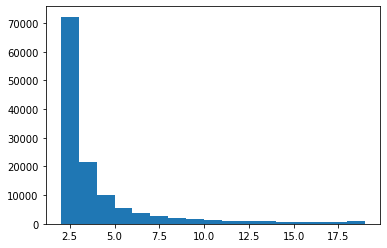

In [22]:
import matplotlib.pyplot as plt
from collections import Counter

res = Counter(list(train_df['score'].values))

plt.hist(res.values(), bins=range(2, 20))
plt.show()

In [31]:
ref_sents_df

,pmid,ref_id,pub_type,ref_pmid,sent_type,sent_id,sentence
0,11978898,R2,journal,9657795,general,0,Deliberate self-poisoning has reached epidemic...
1,11978898,R12,journal,8783813,general,8,In vitro experiments have shown that oximes ar...
2,11978898,R13,journal,8481105,general,8,In vitro experiments have shown that oximes ar...
3,11978898,R15,journal,9292288,general,8,In vitro experiments have shown that oximes ar...
4,11978898,R12,journal,8783813,general,10,"It has now become clear, however, that the deg..."
5,11978898,R13,journal,8481105,general,10,"It has now become clear, however, that the deg..."
6,11978898,R13,journal,8481105,general,48,Detailed observational clinical studies sugges...
7,11978898,R15,journal,9292288,general,48,Detailed observational clinical studies sugges...
8,11978898,R41,journal,11374168,general,48,Detailed observational clinical studies sugges...
9,11978898,R14,journal,9292287,general,14,The half-life of ageing of dimethylphosphoryla...


In [14]:
paper_ref = sentences_df[sentences_df['pmid']==26194312]['sentence'].values

In [15]:
papers_to_check = list(set(ref_sents_df[ref_sents_df['pmid']==26194312]['ref_pmid'].values))

In [16]:
len(papers_to_check)

102

18. A test of several paper summarization into review one. 

In [10]:
from model import Summarizer as BertSum

In [15]:
model = BertSum('bert', 512)
model.load('bert_sum')
model.froze_backbone("froze_all")
model.unfroze_head()

In [16]:
model.eval()
model, device = setup_single_gpu(model)


In [17]:
model_ref=model

In [ ]:
# Features-related evaluation is commented right now.
test_stat = {'rev_pmid':[], 'sent_num':[], 'true_rouge':[], 'diff_papers': []} #'rouge': [], 
inter = set(sentences_df['pmid'].values) & set(ref_sents_df['ref_pmid'].values)
review_papers = list(set(ref_sents_df[ref_sents_df['ref_pmid'].isin(inter)]['pmid'].values))
print(len(review_papers))
cnt = 0
for rev_id in review_papers:
    print(f"\r{rev_id} {cnt}", end="")
    cnt += 1
    paper_ref = sentences_df[sentences_df['pmid']==rev_id]['sentence'].values
    papers_to_check = list(set(ref_sents_df[ref_sents_df['pmid']==rev_id]['ref_pmid'].values))
    result = {'pmid':[], 'sentence':[], 'score':[]}
    for paper_id in papers_to_check:
        ex = test[test['pmid'] == paper_id]
        paper = ex['sentence'].values
        #features = np.nan_to_num(ex[['sent_id', 'sent_type', 'r_abs',
        #                   'num_refs', 'mean_r_fig', 'mean_r_tab', 
        #                   'min_r_fig', 'min_r_tab',
        #                   'max_r_fig', 'max_r_tab']].values.astype(float))
        total_sents = 0
        while total_sents < len(paper):
            magic = max(0, total_sents - 5)
            article_ids, article_mask, article_segment, n_setns = \
            preprocess_paper_bert(paper[magic:], 512, model_ref.tokenizer)
            if n_setns <= 5:
                total_sents += 1
                continue
            old_total = total_sents
            total_sents = magic + n_setns
            input_ids = torch.tensor([article_ids]).to(device)
            input_mask = torch.tensor([article_mask]).to(device)
            input_segment = torch.tensor([article_segment]).to(device)
            #input_features = [torch.tensor(e, dtype=torch.float) for e in features[magic:total_sents]]
            #input_features = torch.stack(input_features).to(device)
            #print(input_features)
            draft_probs = model(
                        input_ids, input_mask, input_segment, #input_features,
                    )
            result['pmid'].extend([paper_id] * (total_sents - old_total))
            result['sentence'].extend(list(paper[old_total:total_sents]))
            result['score'].extend(list(draft_probs.cpu().detach().numpy())[old_total - magic:])
    res_df = pd.DataFrame(result)
    sorted_arr = sorted(list(res_df['score'].values))
    for i in range(5, 103, 5):
        if len(sorted_arr) < i:
            break
        treshold = sorted_arr[-i]
        final_text = res_df[res_df['score'] >= treshold][['pmid', 'sentence']]
        #mean_score = 0
        #num = 0
        #for sent in final_text['sentence'].values:
        #    for ref_sent in paper_ref:
        #        try:
        #            mean_score += get_rouge(sent, ref_sent)
        #            num += 1
        #        except Exception:
        #            continue
        real_score = get_rouge(" ".join(final_text['sentence'].values), " ".join(paper_ref))
        mean_score /= num
        test_stat['rev_pmid'].append(rev_id)
        test_stat['sent_num'].append(i)
        #print(len(" ".join(final_text['sentence'].values)), len(" ".join(paper_ref)))
        
        
        #test_stat['rouge'].append(mean_score)
        test_stat['true_rouge'].append(real_score)
        test_stat['diff_papers'].append(len(set(final_text['pmid'])))
            

In [46]:
print(*[len(arr) for key, arr in test_stat.items()])

53 53 52 52 52


In [58]:
test_stat_df = pd.DataFrame(test_stat)


In [59]:
test_stat_df

,rev_pmid,sent_num,true_rouge,diff_papers
0,29679617,5,7.561977,1
1,29679617,10,11.176846,1
2,29679617,15,13.307740,1
3,29679617,20,15.171123,1
4,29679617,25,17.081815,2
5,29679617,30,19.529945,2
6,29679617,35,20.289010,2
7,29679617,40,21.713557,2
8,29679617,45,22.333436,2
9,29679617,50,23.463143,2


In [60]:
test_stat_df = test_stat_df[test_stat_df['rev_pmid'] != 29574033]

In [61]:
test_stat_df.to_csv("~/simple_right_test_on_review.csv", index=False)

In [57]:
len(result['sentence'])

200

In [19]:
len(result['score'])

7343

In [20]:
res_df = pd.DataFrame(result)

In [21]:
res_df

,pmid,sentence,score
0,20538373,Autopsy brain studies found no strict relation...,0.097209
1,20538373,Jack and colleagues showed that many of normal...,0.084595
2,20538373,The availability of several validated biomarke...,0.083641
3,20538373,Which better predicts AD?,0.083483
4,20538373,All these markers are validated enough to be u...,0.083497
5,20538373,Jack and colleagues ( xref_bibr_R28 ) pointed ...,0.088922
6,20538373,"The open challenge, now, is to try to order bi...",0.088787
7,20538373,This would enable us to express the disease pr...,0.088614
8,20538373,"Furthermore, understanding the temporal order ...",0.088178
9,20538373,Among the most validated biomarkers described ...,0.088869


In [38]:
treshold = sorted(list(res_df['score'].values))[-5]

In [39]:
final_text = res_df[res_df['score'] >= treshold][['pmid', 'sentence']]

In [40]:
len(set(final_text['pmid']))

5

In [25]:
" ".join(final_text['sentence'].values)

'CSF Apo-E levels before treatment together with CSF Apo-E levels after treatments could be used to monitor baseline Apo-E levels, target engagement and correlations between the extent of target engagement and observed response in studies involving LXR. It should be stressed that while most studies, including ours reported here, showed decreased CSF α-syn levels in PD patients [ xref_bibr_R51 , xref_bibr_R12 , xref_bibr_R19 , xref_bibr_R33 , xref_bibr_R34 , xref_bibr_R9 ], results on CSF α-syn reported in AD subjects are highly variable. Ott et al [ xref_bibr_R148 ] studied the relationship between CSF biomarkers and ventricular expansion with the hypothesis that ventricular dilation may reflect faulty CSF clearance mechanisms resulting in reduced levels of Aβ. Of note, recent studies xref_bibr_R17 , xref_bibr_R22 , xref_bibr_R21 have used a multiplex immunoassay panel to examine changes in CSF and blood of patients with AD and mild cognitive impairment (MCI). The decrease in the Aβ42 

In [36]:
mean_score = 0
num = 0
for sent in final_text['sentence'].values:
    for ref_sent in paper_ref:
        mean_score += get_rouge(sent, ref_sent)
        num += 1
mean_score /= num

In [37]:
mean_score

9.816607557249643

In [72]:
" ".join(final_text)

"In particular, emerging evidence from both genetic at-risk and aging cohorts suggests that there may be a time lag of a decade or more between the beginning of the pathological cascade of AD and the onset of clinically evident impairment. We postulate that AD begins with a long asymptomatic period during which the pathophysiological process is progressing, and that individuals with biomarker evidence of early AD-P are at increased risk for developing cognitive and behavioral impairment and progression to AD dementia (AD-C). The extent to which biomarkers of AD-P predict a cognitively normal individual's subsequent clinical course remains to be clarified, and we acknowledge that some of these individuals will never manifest clinical symptoms in their lifetime. Plausibly, this could indicate that as AD progresses, there is an insufficient response to neuronal injury and that there is an impaired repair response. Accordingly, those subjects with lower CSF Apo-E levels progressed faster. 

In [16]:
inter = list(set(sentences_df['pmid'].values) & set(ref_sents_df['ref_pmid'].values))

In [18]:
26194312 in inter

False

In [14]:
ref_sents_df[ref_sents_df['ref_pmid']==25559091]

,pmid,ref_id,pub_type,ref_pmid,sent_type,sent_id,sentence
327976,26194312,R118,journal,25559091,general,224,Some specific single nucleotide variants in no...


In [62]:
import pandas as pd

test_stat_df = pd.read_csv("~/simple_right_test_on_review.csv")
ft_test_stat_df = pd.read_csv("~/bertsum_test_on_review.csv")

In [63]:
df_1 = test_stat_df.assign(model = ['Основная модель']*len(test_stat_df))

In [64]:
df_2 = ft_test_stat_df.assign(model = ['BERTSUM']*len(ft_test_stat_df))

In [65]:
draw_df = pd.concat([df_1, df_2])

/home/student/miniconda3/envs/pubtrends/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [44]:
rouge_means = []
rouge_err = []
papers_means = []
papers_err = []

for i in range(5, 103, 5):
    tmp = test_stat_df.groupby(['sent_num']).get_group(i)
    rouge_means.append(tmp['rouge'].mean())
    rouge_err.append(tmp['rouge'].std())
    papers_means.append(tmp['diff_papers'].mean())
    papers_err.append(tmp['diff_papers'].std())
    

In [3]:
import matplotlib.pyplot as plt

<ErrorbarContainer object of 3 artists>

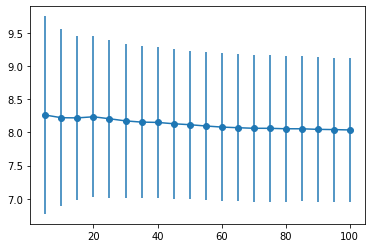

In [48]:
plt.errorbar(list(range(5, 103, 5)), rouge_means, yerr=rouge_err, fmt='-o')

<ErrorbarContainer object of 3 artists>

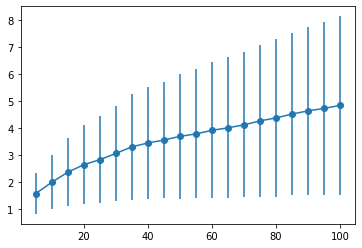

In [50]:
plt.errorbar(list(range(5, 103, 5)), papers_means, yerr=papers_err, fmt='-o')

In [5]:
!pip install seaborn


     |████████████████████████████████| 215 kB 1.0 MB/s eta 0:00:01


In [30]:
import seaborn as sns


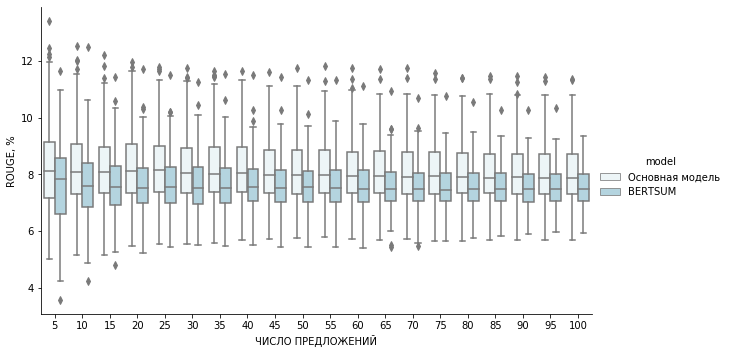

In [45]:
sns.catplot(x="sent_num", y="rouge", kind="box", hue='model', aspect=1.7, color='lightblue', data=draw_df).set_axis_labels("ЧИСЛО ПРЕДЛОЖЕНИЙ", "ROUGE, %")

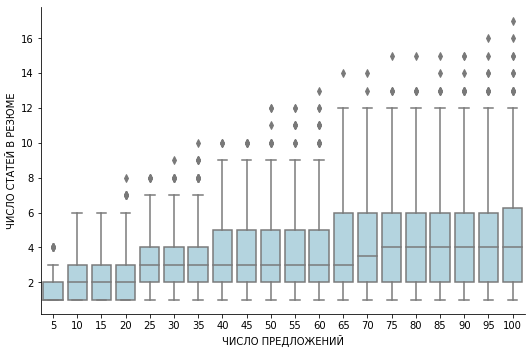

In [28]:
sns.catplot(x="sent_num", y="diff_papers", kind="box", aspect=1.5, color = 'lightblue', data=test_stat_df).set_axis_labels("ЧИСЛО ПРЕДЛОЖЕНИЙ", "ЧИСЛО СТАТЕЙ В РЕЗЮМЕ")

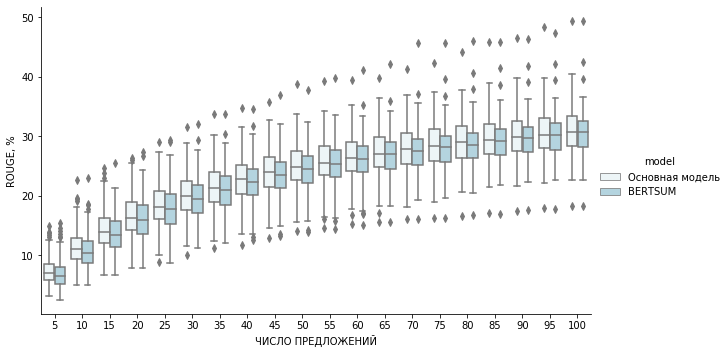

In [66]:
sns.catplot(x="sent_num", y="true_rouge", kind="box", aspect=1.7, hue='model', color='lightblue', data=draw_df).set_axis_labels("ЧИСЛО ПРЕДЛОЖЕНИЙ", "ROUGE, %")